In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import scipy.stats
from IPython.display import Video, display, HTML
sns.set()

def read_csvx(path, *args, **kwargs):
    try:
        return pd.read_csv(str(path) +'.gz', *args, **kwargs)
    except Exception as e:
        return pd.read_csv(str(path), *args, **kwargs)

def followorbit(vals, path):
    out = []
    for n in range(100):
        closest05 = np.clip(round(path[n] * 2) / 2, 0, 10)
        rank = vals.query(f'nbopp == {n} and othercoop == {closest05}')['rank'].values[0]
        out.append(rank)
    return np.array(out)

import re
def gethighest(vals, prefix="logall_"):
        m = np.argmax([int(re.search(f'{prefix}(\d+)', val).group(1)) for val in vals])
        return vals[m]

    
def readparams(file):
    params = {} 
    with open(file) as f:
        for line in f:
            line = line[:-1]  # remove \n
            if not line or line.startswith('#') or line.startswith('import'):
                continue
            key, val = line.split('=')
            if val.lower() == 'true' or val.lower() == 'false':
                params[key] = val.lower() == 'true'
            else:
                try:
                    params[key] = float(val)
                except ValueError:
                    params[key] = val
    return params

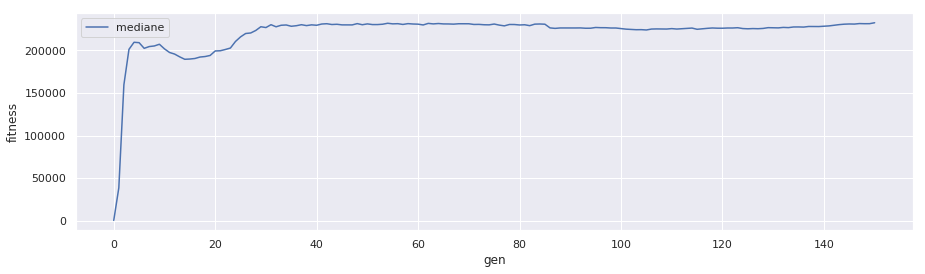

ind coop = 0


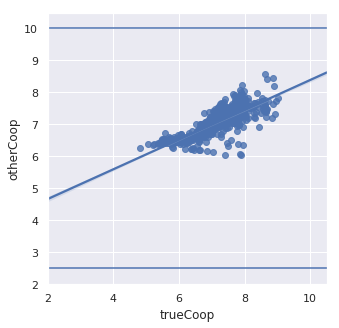

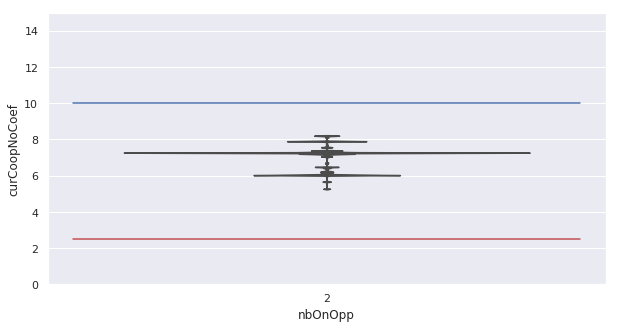

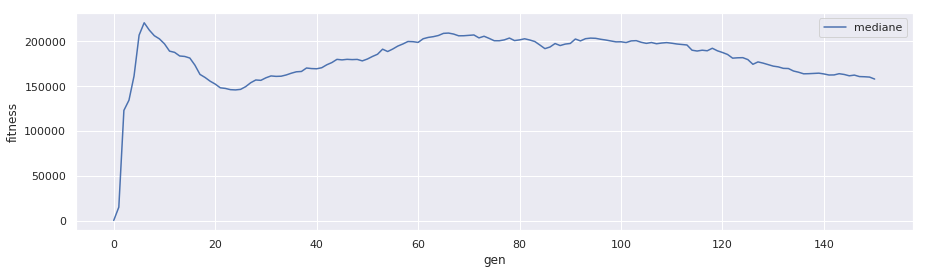

ind coop = 0


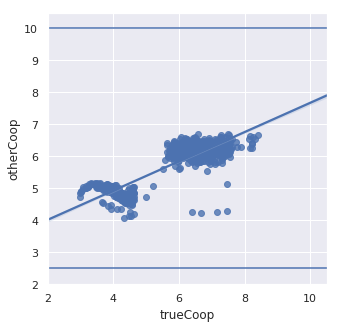

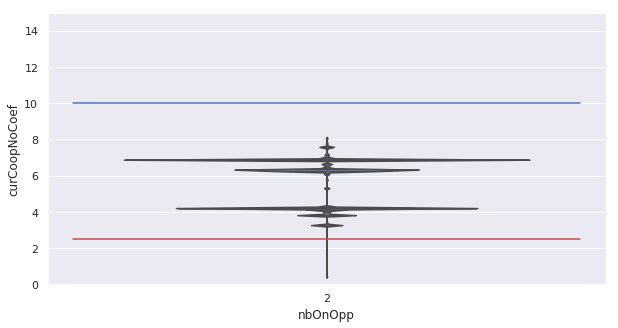

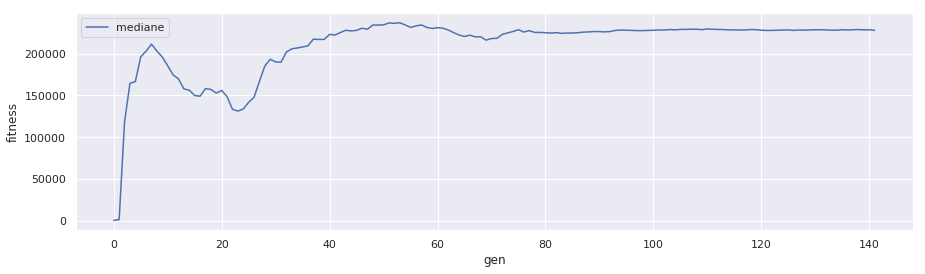

ind coop = 0


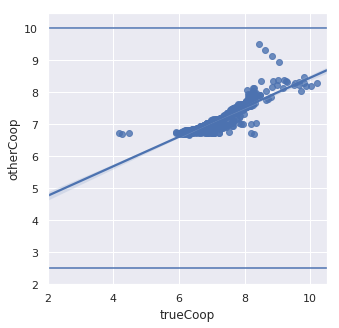

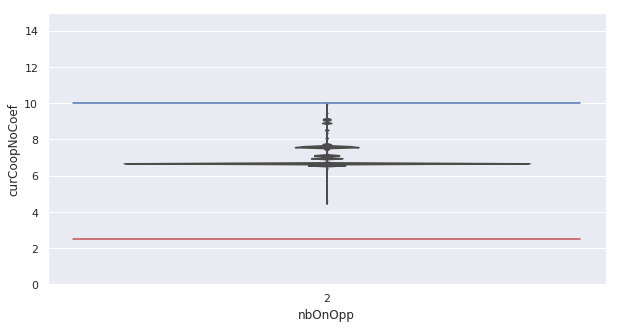

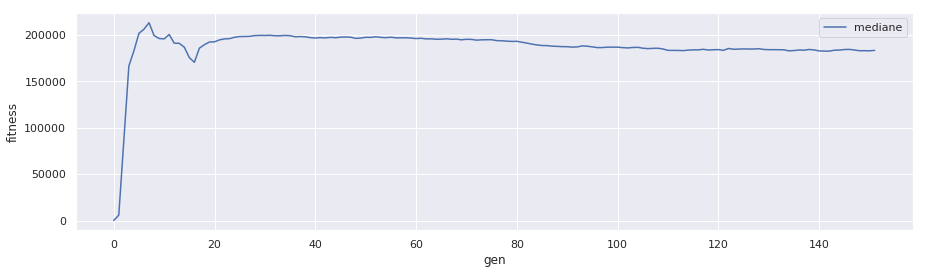

ind coop = 0


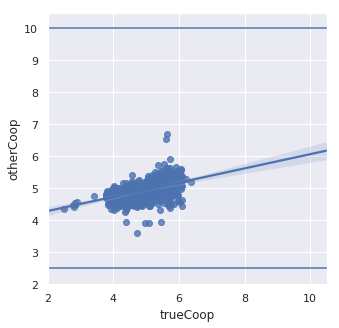

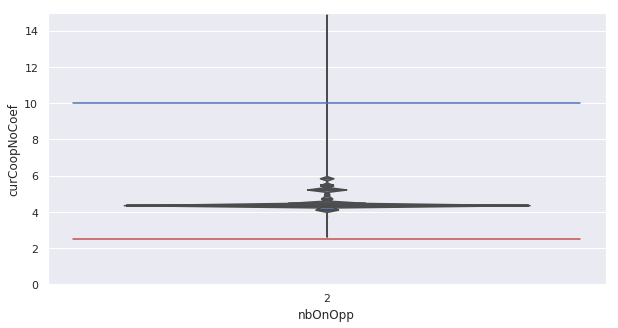

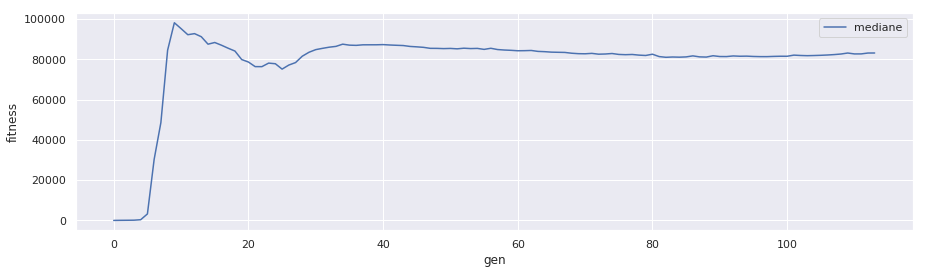

ind coop = 0


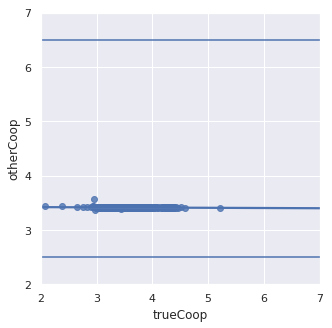

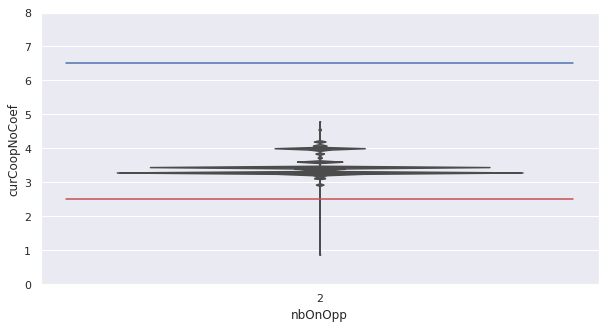

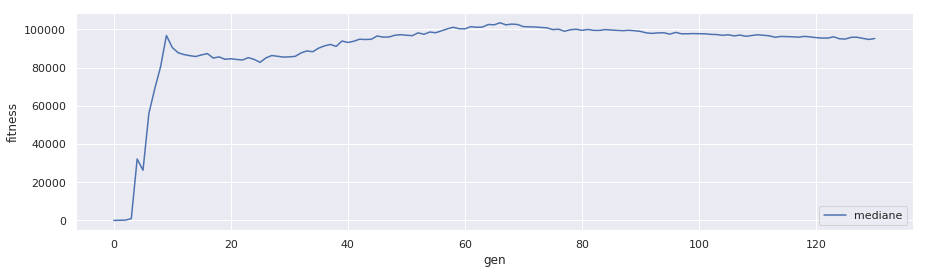

ind coop = 0


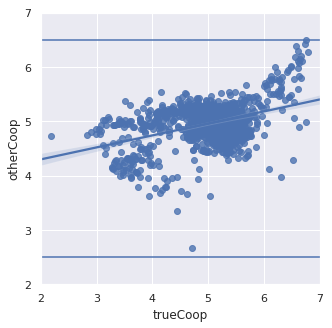

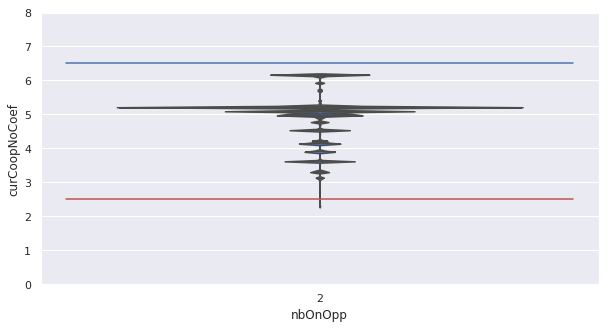

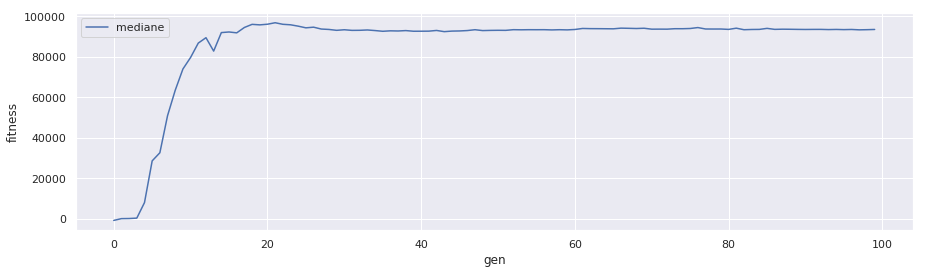

ind coop = 0


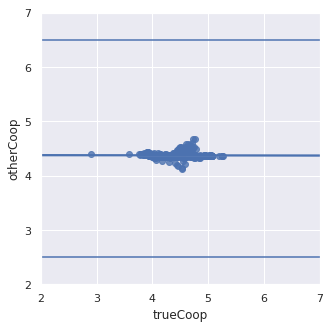

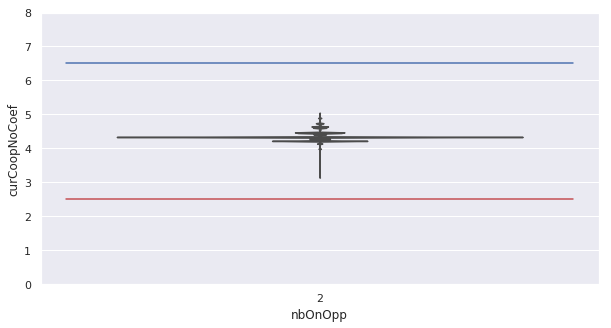

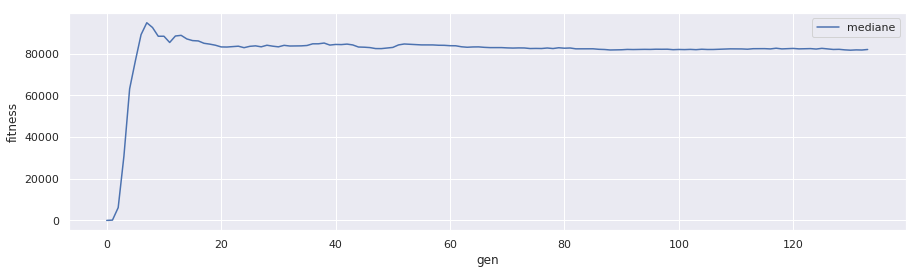

ind coop = 0


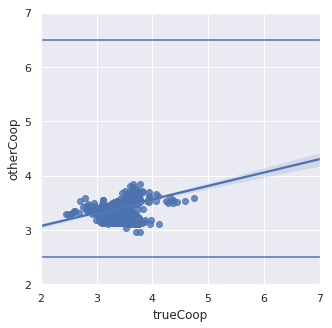

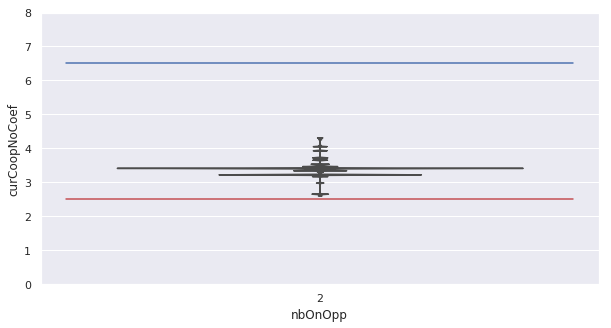

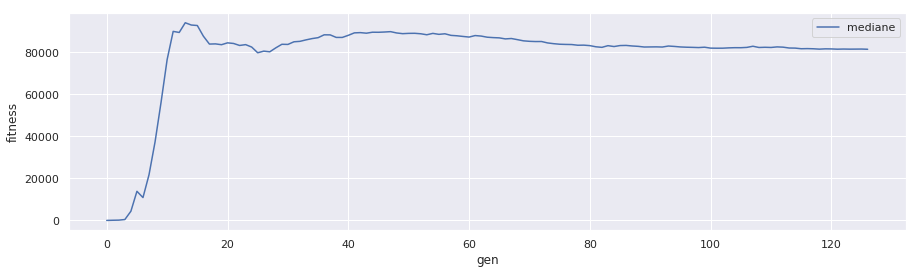

ind coop = 0


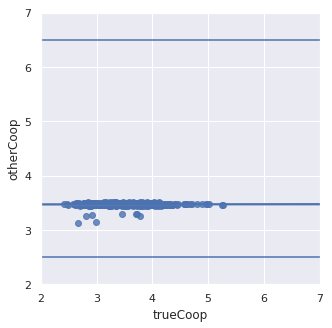

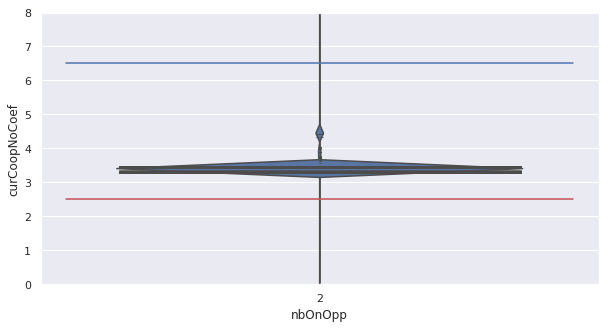

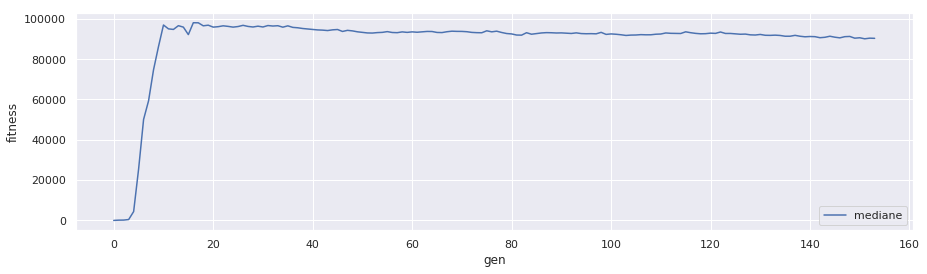

ind coop = 0


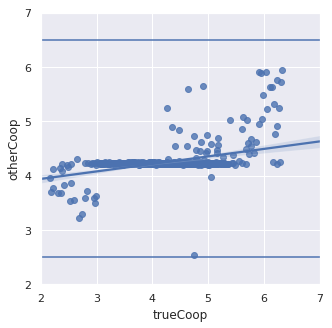

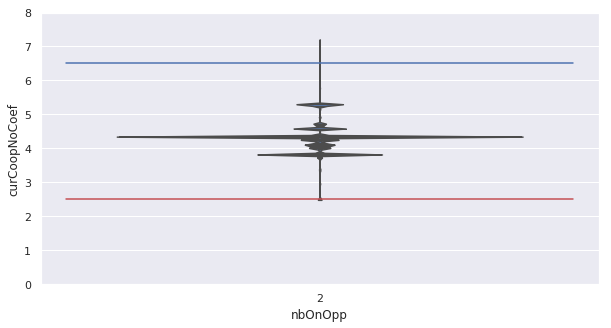

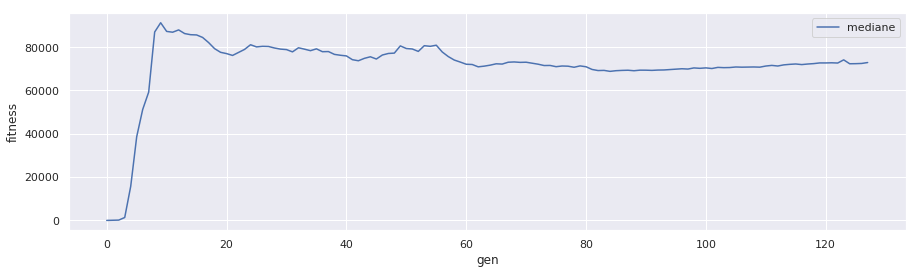

ind coop = 0


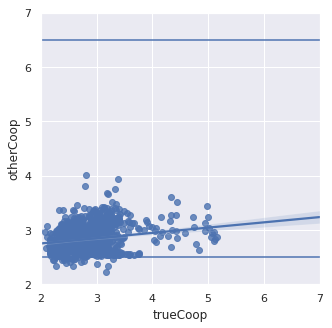

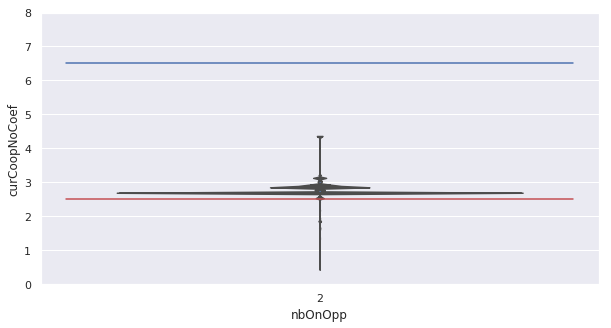

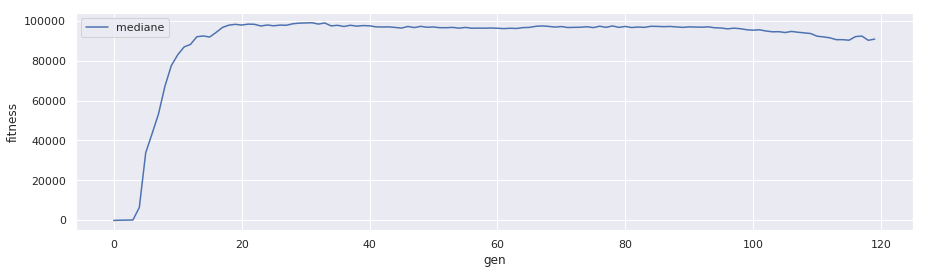

ind coop = 0


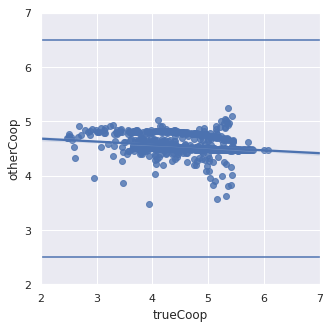

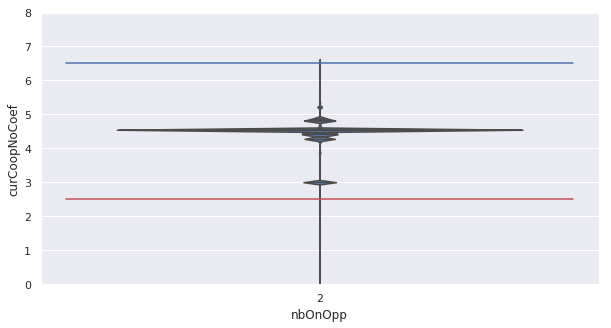

In [20]:
dofolloworbit = True
for path in sorted(glob.glob("../../../../logs/lions-maxtwo**-2019-06-19*/**/rep00/", recursive=True)):
    display(HTML(f'<h3>{path}</h3>'))
    fit = read_csvx(path + "fitnesslog.txt", delimiter="\t")
    fit = fit.groupby(['gen', 'ind'], as_index=False).sum()
    plt.figure(figsize=(15, 4))
    sns.lineplot(y='fitness', x='gen', data=fit, ci=None, estimator='median', label="mediane")
    plt.legend()
    #sns.lineplot(y='fitness', x='gen', data=fit, ci=None, estimator='min')
    plt.show()
    
    
    try:
        logall = read_csvx(gethighest(glob.glob(path + 'logall*')), delimiter="\t")
    except Exception as e:
        print(e)
        continue
        
    params = readparams(glob.glob(path + 'properties*')[0])
    indcoop = params.get('independantCoop', 0)
    logall['ess'] = params['meanA'] / logall['nbOnOpp']
    ess2 = params['meanA'] / 2
    so2 = params['meanA'] + params['b'] - (params['b'] /2)
    logall['so'] = params['meanA'] + params['b'] - (params['b'] /logall['nbOnOpp'])
    logall['oppId'] = logall['oppId'].astype('category')
    logall['trueCoop'] = logall['curCoopNoCoef'] if indcoop > 0 else logall['curCoopNoCoef'] * logall['fakeCoef']
    
    # print if ind coop or not
    print('ind coop =', indcoop)
    
    # Coop corr
    plt.figure(figsize=(5, 5))
    logall[['previt', 'prevother', 'prevoppid']] = logall.shift(periods=logall['id'].max()+1)[['iter', 'otherCoop', 'oppId']]
    #sns.regplot('curCoopNoCoef', 'otherCoop', logall.query('nbOnOpp == 2 and prevother == otherCoop and oppId == prevoppid').groupby(['id']).mean())
    plt.ylim(ess2 - 0.5, so2 + 0.5)
    plt.xlim(ess2 - 0.5, so2 + 0.5)
    sns.regplot('trueCoop', 'otherCoop', logall.query('nbOnOpp == 2').groupby(['id']).mean())

    plt.axhline(ess2)
    plt.axhline(so2)
    plt.show()
    
    # Coop graph
    coopval = logall.query('nbOnOpp == 2').groupby(['nbOnOpp', 'id'], as_index=False).mean()
    plt.figure(figsize=(10, 5))
    sns.violinplot(data=coopval, x='nbOnOpp', y='curCoopNoCoef', bw=0.02, inner='sticks')
    plt.ylim(0, params['meanA'] + params['b'])
    for i in range(1, 2):
        a = params['meanA'] / (i+1)
        b = params['meanA'] + params['b'] * i / (i+1)
        plt.plot([i-1.5, i-0.5], [b, b], c="b")
        plt.plot([i-1.5, i-0.5], [a, a], c="r")

    plt.show()
    
    if False:
        # Occupancy
        plt.figure(figsize=(20, 10))
        occupancy = logall.query('eval == 0').groupby(['iter', 'oppId'], as_index=False).count()
        occupancy['logid'] = np.log(occupancy['id'])
        sns.heatmap(occupancy.pivot_table('logid', 'oppId', 'iter', fill_value=0))
        plt.show()

        allopps = logall['oppId'].unique()
        for ind in [0, 10, 20]:
            subdf = logall.query(f'id == {ind} and eval == 0')
            a = subdf.pivot_table('id', 'iter', 'oppId', aggfunc='count', fill_value=0)
            # trick for add all the opps
            for oppval in allopps:
                if oppval not in a:
                    a[oppval] = 0
            a.sort_index(axis=1, inplace=True)
            a = a.transpose()
            # end of trick 

            fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

            sns.lineplot(y='nbOnOpp', x='iter', sort=False, data=subdf, ax=axs[0])

            sns.lineplot(y='ess', x='iter', sort=False, data=subdf, ax=axs[1], label="ess")
            sns.lineplot(y='so', x='iter', sort=False, data=subdf, ax=axs[1], label="so")
            sns.lineplot(y='curCoopNoCoef', x='iter', sort=False, data=subdf, ax=axs[1], label="played")
            sns.heatmap(a, ax=axs[2], cbar=False)
            axs[0].set_ylim(0, None)
            axs[1].set_ylim(0, 10)
            axs[1].legend()
            plt.show()


In [114]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [95]:
rob = 0
print(df.loc[(df['id'] == rob) & (df['iter'] == i), 'otherCoop'])
i = 1
df = logall
df.loc[(df['id'] == rob) & (df['iter'] == i-1), 'prevother']= df.loc[(df['id'] == rob) & (df['iter'] == i), 'otherCoop']

100    5.32828
Name: otherCoop, dtype: float64


In [98]:
%%cython
def putprev(df):
    df['prevother'] = False
    for rob in df['id'].unique():
        for i in range(1, df['iter'].max()):
            df.loc[(df['id'] == rob) & (df['iter'] == i-1), 'prevother'] = df.loc[(df['id'] == rob) & (df['iter'] == i), 'otherCoop']

In [104]:
logall[['previt', 'prevother', 'previd']] = logall.shift(periods=df['id'].max()+1)[['iter', 'otherCoop', 'id']]

In [105]:
logall

,eval,iter,id,a,fakeCoef,playing,oppId,nbOnOpp,curCoopNoCoef,otherCoop,ess,so,prevother,previt,previd
0,0,0,0,5,0.722222,1,33,2,3.38889,5.32828,2.5,6.5,NaN,NaN,NaN
1,0,0,1,5,1.176770,1,14,2,5.20707,4.11616,2.5,6.5,NaN,NaN,NaN
2,0,0,2,5,1.358590,1,39,2,5.93434,4.27778,2.5,6.5,NaN,NaN,NaN
3,0,0,3,5,0.601010,1,40,2,2.90404,4.35859,2.5,6.5,NaN,NaN,NaN
4,0,0,4,5,0.611111,1,20,2,2.94444,5.00505,2.5,6.5,NaN,NaN,NaN
5,0,0,5,5,1.095960,1,37,2,4.88384,6.13636,2.5,6.5,NaN,NaN,NaN
6,0,0,6,5,1.075760,1,10,2,4.80303,3.18687,2.5,6.5,NaN,NaN,NaN
7,0,0,7,5,0.843434,1,49,2,3.87374,4.84343,2.5,6.5,NaN,NaN,NaN
8,0,0,8,5,1.328280,1,28,2,5.81313,5.40909,2.5,6.5,NaN,NaN,NaN
9,0,0,9,5,0.954545,1,3,2,4.31818,4.92424,2.5,6.5,NaN,NaN,NaN


In [7]:
params

{'ConfigurationLoaderObjectName': 'LionConfigurationLoader',
 'SlowMotionMode': False,
 'VisibleLandmarks': True,
 'b': 3.0,
 'controllerType': 0.0,
 'cost': 0.0,
 'evaluationTime': 1000.0,
 'fakeCoef': 0.5,
 'fakeCoefStd': 0.3,
 'fakeRobots': True,
 'frictionCoef': 0.0,
 'frictionInflexionPoint': 2.5,
 'gAgentsInitAreaHeight': 580.0,
 'gAgentsInitAreaWidth': 580.0,
 'gAgentsInitAreaX': 10.0,
 'gAgentsInitAreaY': 10.0,
 'gBackgroundImageFilename': 'data/env_600_background.bmp',
 'gBatchMode': False,
 'gControllerType': 0.0,
 'gDisplayGroundCaption': False,
 'gDisplayMode': 0.0,
 'gDisplaySensors': 0.0,
 'gDisplayTail': False,
 'gEnergyInit': 400.0,
 'gEnergyLevel': False,
 'gEnergyMax': 400.0,
 'gEnergyRefill': True,
 'gEnergyRequestOutput': True,
 'gEnvironmentImageFilename': 'data/env_600_environment.bmp',
 'gExtendedSensoryInputs': True,
 'gFastDisplayModeSpeed': 60.0,
 'gFixedEffort': False,
 'gFixedEffortValue': 0.25,
 'gFootprintImageFilename': 'data/env_600_background.bmp',
 'gF